In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from unicodedata import normalize
import openpyxl
from collections import defaultdict
import matplotlib.pyplot as plt

# 글자체 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'

In [163]:
test_path = "./data/6_csv/final_data.xlsx"
ref_path = "./data/02_ref_db/ref.xlsx"

test_df = pd.read_excel(test_path,
                        index_col=0)
ref_df = pd.read_excel(ref_path)

In [3]:
# 파일 저장 중 생기는 유니코드 변경 방지 <-- 결측치 제거
test_df["한자"] = test_df["한자"].apply(lambda x : normalize("NFKC", x))
ref_df["한자"] = ref_df["한자"].apply(lambda x : normalize("NFKC", x))

In [164]:
test_df

,출제연도,출제월,과목,지문번호,문제번호,한자
0,2023,11,국어,1,1,答
1,2023,11,국어,1,1,持
2,2023,11,국어,1,1,續
3,2023,11,국어,1,1,的
4,2023,11,국어,1,1,冊
...,...,...,...,...,...,...
83872,2026,9,국어,15,56,反
83873,2026,9,국어,15,56,映
83874,2026,9,국어,15,56,冊
83875,2026,9,국어,15,56,揷


In [165]:
# 참고 데이터가 seaborn 사용 시 텍스트 깨짐 현상 방지
ref_df["등급(기초교육용)"] = ref_df["등급(기초교육용)"].map(
    {"중등" : "middle",
    "고등" : "high",
     "심화" : "others"}
)
# 대한검정회 3급 1000자, 준2급 1500자 / 3급까지 중등(middle), 준2급은 고등(high)로 분류
ref_df["등급(대한검정회)"] = np.select(
    [ref_df["등급(대한검정회)"] >= 3.0,
     ref_df["등급(대한검정회)"] >= 2.5,
     ref_df["등급(대한검정회)"] > 0.0,
     True],
    [3, 2, 1, 0]
)
ref_df["등급(대한검정회)"] = ref_df["등급(대한검정회)"].map(
    {3 : "middle",
    2 : "high",
     1 : "expert",
     0 : "others"}
)
# 대한검정회 4급 1000자, 3급 1800자 / 4급까지 중간(middle), 3급은 고등(high)로 분류
ref_df["등급(한국어문회)"] = np.select(
    [ref_df["등급(한국어문회)"] >= 4.0,
     ref_df["등급(한국어문회)"] >= 3.0,
     ref_df["등급(한국어문회)"] > 0.0,
     True],
    [3, 2, 1, 0]
)
ref_df["등급(한국어문회)"] = ref_df["등급(한국어문회)"].map(
    {3 : "middle",
    2 : "high",
     1 : "expert",
     0 : "others"}
)
# -----------------------------
ref_df

,한자,등급(대한검정회),등급(한국어문회),등급(기초교육용)
0,嫁,expert,expert,others
1,稼,expert,expert,others
2,袈,expert,expert,others
3,苛,expert,expert,others
4,駕,expert,expert,others
...,...,...,...,...
3750,鍾,others,middle,others
3751,氷,others,middle,middle
3752,強,others,middle,others
3753,戱,others,others,high


#### 주제 : 현재 정의된 상용한자는 국어 중등교육용으로써 적합한가?
* 단순히 나온 횟수를 기반으로, 적절성을 파악한다.
* 서로 각기 다른 지문에 나온 한자 횟수를 기반으로, 적절성을 파악한다.
* 과목별 가중치를 두어, 적절성을 파악한다. (이거... 가중치 조절이 되면 재밌겠는데?)
* 과목별로, 적절성을 파악한다.
* 기초교육용 한자에 해당하는 한자의 비율을 계산하여, 적절성을 파악한다.
* 대한검정회 및 한국어문회 한자 급수에 해당하는 한자의 비율을 계산하여, 적절성을 파악한다.

* 디폴트는 각 교육기관마다의 적합성. (여기서 디폴트란, 모든 항목이 이 과정을 거친다는 것임)
1. 한자종류수 기반 : 한자를 count하고 합친 후, 한자마다 일정한 비율로 나누어 통계로 산출한다.
2. 단순 한자 수 기반 : 한자를 count하고 합친 후, count 기반의 누적 그래프를 만들어 통계로 산출한다.
3. 가중치 우선 기반 : 한자에 일정한 가중치 식을 적용한 후, 가중치 기반의 누적 그래프를 만들어 통계로 산출한다.
4. 각 과목별 기반 : 데이터를 과목별로 나누어 저장한 후, 셋 중 가장 유효한 분석법 하나를 적용한다.
* 참고로, 가중치식은 w_1 (국어 지문과 그의 문제) + w_2 (사탐 과목별 문제) + w_3 (한국사 문제) 가 될 것으로 예상.

* 이거면 끝날까? Yes! 무리가 독이라고 그러네.

In [ ]:
# 1~3번에 필요한 DataFrame 추가

In [180]:
# 1. 종류(kind) 별
k_val_df = test_df.groupby(
    ["한자"], as_index=False).count().filter(["한자", "문제번호"])
k_val_df.rename(columns={"문제번호":"count"}, inplace=True)
k_val_df

,한자,count
0,一,367
1,丁,4
2,七,7
3,丈,11
4,三,30
...,...,...
2187,狀,8
2188,識,5
2189,切,3
2190,宅,3


In [186]:
# 2. 한자 종류별 (distinct)
d_val_df = test_df.groupby(
    ["한자"], as_index=False).sum().filter(["한자"])
d_val_df["distinct"] = 1
d_val_df

,한자,distinct
0,一,1
1,丁,1
2,七,1
3,丈,1
4,三,1
...,...,...
2187,狀,1
2188,識,1
2189,切,1
2190,宅,1


In [1]:
# 3. 가중치별 (weight)
w_pre_df = test_df.groupby(["출제연도", "출제월", "과목", "지문번호", "한자"]).size().reset_index(name="cnt")

# 3-1. 문제 수에 따른 가중치 기반
"""
평균적으로,
국어 단위 지문 당 약 5.6문제,
사탐 시험 당 20문제,
한국사 시험 20문제로,
이를 통한 가중치 부여.
최종 반영비율(국어 : 사탐 : 한국사) = 1.4 : 5 : 5
"""
w1_map = {
    "국어": 1.4,
    "한국사": 5
}
weight1 = w_pre_df["과목"].map(w1_map).fillna(5)
w_pre_df["cnt"] *= weight1
w1_val_df = (
    w_pre_df
    .groupby("한자", as_index=False)["cnt"]
    .sum()
    .rename(columns={"cnt": "D1"})
    .sort_values("D1", ascending=False)
)

# 3-2. 시험 응시율에 따른 가중치 기반
"""
한국사와 국어는 필수 과목이므로,
문제 수 비례하는 것이 적절 (4:1)

사탐은 20문제로, 국어와 4:1 관계가 되어야 하지만,
사탐의 응시율은, 2개 모두가 59.3%, 1개만이 0.6%이므로,
반올림하여 60% 정도로 반영.
따라서 4:1 -> 2.4:1

최종 반영비율(국어 : 사탐 : 한국사) = 1 : 2.4 : 4
"""
w2_map = {
    "국어": 1.4,
    "한국사": 5
}
weight2 = w_pre_df["과목"].map(w2_map).fillna(5)
w_pre_df["cnt"] *= weight2
w2_val_df = (
    w_pre_df
    .groupby("한자", as_index=False)["cnt"]
    .sum()
    .rename(columns={"cnt": "D2"})
    .sort_values("D2", ascending=False)
)
# 보기 그러니 합칠까?
w_val_df = pd.merge(
    w1_val_df, w2_val_df,
    on="한자"
)
w_val_df

NameError: name 'test_df' is not defined

In [173]:
# 1. 단순 횟수를 기반
result1_df = pd.DataFrame.merge(
    pd.DataFrame(test_df["한자"].value_counts()),
    ref_df,
    how="left",
    on="한자"
)
# result1_df[result1_df["등급(대한검정회)"].isnull()]
result1_df

,한자,count,등급(대한검정회),등급(한국어문회),등급(기초교육용)
0,對,1006,middle,middle,middle
1,的,995,middle,middle,middle
2,人,785,middle,middle,middle
3,生,719,middle,middle,middle
4,者,659,middle,middle,middle
...,...,...,...,...,...
2187,爽,1,others,expert,others
2188,閨,1,expert,expert,others
2189,欠,1,expert,expert,others
2190,余,1,middle,high,others


In [168]:
rank_ref_names = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]

y_total = {name:[0, 0, 0, 0] for name in rank_ref_names}

y_cum = {name:[] for name in rank_ref_names}

x = result1_df.index

for i in x:
    for k in y_total.keys():
        if result1_df.loc[i, k] == "middle":
            y_total[k][0] += 1
        elif result1_df.loc[i, k] == "high":
            y_total[k][1] += 1
        elif result1_df.loc[i, k] == "expert":
            y_total[k][2] += 1
        else:
            y_total[k][3] += 1
        y_cum[k].append(y_total[k][:])

for k in y_cum.keys():
    y_cum[k] = pd.DataFrame(y_cum[k], columns=["middle", "high", "expert", "others"])
y_cum[rank_ref_names[1]]

,middle,high,expert,others
0,1,0,0,0
1,2,0,0,0
2,3,0,0,0
3,4,0,0,0
4,5,0,0,0
...,...,...,...,...
2187,976,615,459,138
2188,976,615,460,138
2189,976,615,461,138
2190,976,616,461,138


In [169]:
ref_rank = {name:ref_df.groupby(name).count().filter(["한자"])["한자"]
                 for name in rank_ref_names}
rank_total = pd.DataFrame(ref_rank).fillna(0).astype("int32")
rank_total

,등급(대한검정회),등급(한국어문회),등급(기초교육용)
expert,1559,1683,0
high,500,817,900
middle,1000,1000,600
others,696,255,2255


In [159]:
for i in rank_ref_names:
    y_cum[i] /= rank_total[i]

y_cum

{'등급(대한검정회)':       middle   high   expert    others
 0      0.001  0.000  0.00000  0.000000
 1      0.002  0.000  0.00000  0.000000
 2      0.003  0.000  0.00000  0.000000
 3      0.004  0.000  0.00000  0.000000
 4      0.005  0.000  0.00000  0.000000
 ...      ...    ...      ...       ...
 2204   0.935  0.842  0.37075  0.389368
 2205   0.936  0.842  0.37075  0.389368
 2206   0.937  0.842  0.37075  0.389368
 2207   0.938  0.842  0.37075  0.389368
 2208   0.938  0.844  0.37075  0.389368
 
 [2209 rows x 4 columns],
 '등급(한국어문회)':       middle      high    expert    others
 0      0.001  0.000000  0.000000  0.000000
 1      0.002  0.000000  0.000000  0.000000
 2      0.003  0.000000  0.000000  0.000000
 3      0.004  0.000000  0.000000  0.000000
 4      0.005  0.000000  0.000000  0.000000
 ...      ...       ...       ...       ...
 2204   0.974  0.752754  0.273916  0.607843
 2205   0.975  0.752754  0.273916  0.607843
 2206   0.976  0.752754  0.273916  0.607843
 2207   0.976  0.753978  0

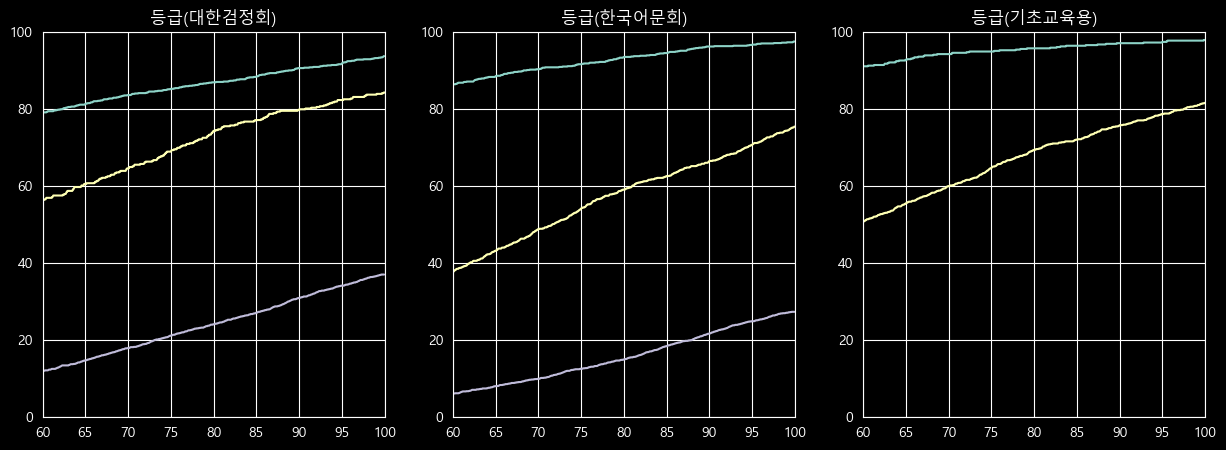

In [160]:
# 기관별 한자분포표
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = (result1_df.index / len(result1_df.index)) * 100

for i in range(3):
    ay = y_cum[rank_ref_names[i]]["middle"] * 100
    by = y_cum[rank_ref_names[i]]["high"] * 100
    cy = y_cum[rank_ref_names[i]]["expert"] * 100

    axes[i].plot(x, ay)
    axes[i].plot(x, by)
    axes[i].plot(x, cy)
    axes[i].set(xlim=(60, 100), ylim=(0, 100))

    axes[i].set_title(rank_ref_names[i])
"""
x = (data.index / len(data.index)) * 100
ay = data["middle"] * 100
by = data["high"] * 100
cy = data["others"] * 100
y = np.vstack([ay, by, cy])

fig, ax = plt.subplots()
ax.plot(x, ay)
ax.plot(x, by)
ax.plot(x, cy)
ax.set(xlim=(50, 100), ylim=(0, 100))
"""
plt.show()

In [ ]:
prop = 65

its = result1_df[result1_df["proportion"] > prop]["proportion"].tolist() # {prop}% 초과의 확률 iterator

check_types = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]
c_type = 2  # 이곳을 바꾸면 비교 대상을 바꿀 수 있습니다.

record = []

for p in its:
    result1_df2_left = pd.merge(result1_df2.iloc[0:int(len(result1_df) * p)],
                                ref_df.value_counts(check_types[c_type]),
                                how="inner",
                                on=check_types[c_type]
                                )
    result1_df_right = (result1_df2_left["count_x"] / result1_df2_left["count_y"] * 100)
    result1_dict = result1_df_right.to_dict()

    for k in result1_dict.keys():
        record.append([p, k, result1_dict[k]])

result1_df3 = pd.DataFrame(record)
result1_df3.columns = ["p", "rank", "rank_p"]
# result1_df3
pd.DataFrame(record)

In [ ]:
# 출제 한자 적중률 비교
g1 = sns.relplot(
    data=result1_df3,
    x="p",
    y="rank_p",
    hue="rank",
    kind="line",
)
g.set(xlim=(70, 100), ylim=(0, 100))
"""
70% : 36.5 / 6.6 / 0.0
82.5% : 54.2 / 11.4 / 1.0
95% : 79.4 / 30.8 / 5.7
"""


In [ ]:
# 상용기관별

## 2. D의 가중치 반영
* 단어가 한번만 나타나도, 그 단어의 뜻을 모른다면 논증을 파악하기가 매우 힘들다.
* 다만 여러번 나타난다고 해서 의미가 달라지지 않는다.
* 정말 드물게 나타나면, 어느 정도 문맥흐름으로 커버가 가능하지만, 다수가 나오면 커버가 힘들다.
* 따라서, log함수를 적용하는 것이 제일 적합하다고 판단.

In [ ]:
# 2. 가중치 기반
result2_df = pd.DataFrame(test_df)
result2_df2 = result2_df.groupby(by=["출제연도", "출제월", "과목", "지문번호", "한자"], as_index=False).sum()
result2_df2["D"] = result2_df2["문제번호"] ** 0.2
result2_df2

In [ ]:

result21_df = result2_df2.loc[:, :]
result21_df["D"] = np.select(
    [(result21_df["과목"] == "국어"), (result21_df["과목"] == "한국사"), True],
    [result21_df["D"] * 1.4, result21_df["D"] * 5.0, result21_df["D"] * 5.0]
)
result21_df

In [ ]:
# 한자 그룹화

In [ ]:
# 누적 확률 분포 데이터 추가
result21_df2 = result21_df.loc[:, :]
result21_df2["proportion"] = (result21_df2["D"] / result21_df2["D"].sum()).cumsum() * 100
result21_df2

In [ ]:
result21_df3 = pd.DataFrame.merge(
    result21_df2.filter(["한자", "proportion", "D"]),
    ref_df,
    how="left",
    on="한자"
).dropna()
result21_df3

In [ ]:
prop = 65

its = result21_df3[result21_df3["proportion"] > prop]["proportion"].tolist() # {prop}% 초과의 확률 iterator

check_types = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]
c_type = 2     # 이곳을 바꾸면 비교 대상을 바꿀 수 있습니다.

record = []

for p in its:
    result21_df4_left = pd.merge(result21_df3[result21_df3["proportion"] < p].value_counts(check_types[c_type]),
                                ref_df.value_counts(check_types[c_type]),
                                how="inner",
                                on=check_types[c_type]
                                )
    result21_df4_right = (result21_df4_left["count_y"] / result21_df4_left["count_x"] * 100)
    result21_dict = result21_df4_right.to_dict()

    for k in result21_dict.keys():
        record.append([p, k, result21_dict[k]])

result21_df4 = pd.DataFrame(record)
result21_df4.columns = ["p", "rank", "rank_p"]
result21_df4

In [ ]:
# 출제 한자 적중률 비교
g2 = sns.relplot(
    data=result21_df4,
    x="p",
    y="rank_p",
    hue="rank",
    kind="line",
)
g.set(xlim=(70, 100), ylim=(0, 100))
"""
70% : 36.5 / 6.6 / 0.0
82.5% : 54.2 / 11.4 / 1.0
95% : 79.4 / 30.8 / 5.7
"""

In [ ]:
# 2-2. 시험 응시율에 따른 가중치 기반

result22_df = result2_df2
result22_df["D"] = np.select(
    [(result21_df["과목"] == "국어"), (result21_df["과목"] == "한국사"), True],
    [result21_df["D"], result21_df["D"] * 2.4, result21_df["D"] * 4]
)
result22_df

In [ ]:
result22_df2 = result22_df.groupby(["한자"]).sum().filter(["한자","D"])
result22_df2

## 발표를 한다면,
1. 나 "현재 정의된 상용한자는 국어 중등교육용으로써 적합한가?" 로 함.
* 상용한자들을 제시하지만, 실제로 이를 다 아는 사람들은 거의 보기 힘듬.
* 지금 나온 상용한자들, 한문교육 위주 중심으로 나와서, 그런 것으로 '생각'하고 있음.
* 근데 이런 상용한자들은 한문교육엔 적합한지 몰라도, 국어교육에 적합하다는 분석은 없음.
* 그래서 분석하게 됨.

2. 데이터 구하는 과정
* 수능 데이터 뽑음. 그 이유는, 중등교육의 최종보스가 수능이기 때문임.
* 최종보스라고 보는 이유는, 5년간 수능 응시율이 늘어났기 때문임.
* 그리고 수능은 중등교육의 전반적인 과정을 평가하는 것이기 때문에, 이걸 데이터셋으로 뽑는게 타당함.
* 이유는 여기까지고,
* 데이터가 뭐 있는지 소개함.
* 이 데이터가 pdf, txt, 가공, gemini, excel.. 등의 과정을 간단하게, 압축적으로 설명할거임.

3. 분석 과정
* 아까 말한 분석 항목을 기준으로, 분석할거임.
* 이런 분석을 했더니, 이런 결과가 나오는거임.
* 그게 최대 12개 관점(실제로는 4페이지로 압축되지 않을까)로 제시될거임.
* 그래서 데이터를 볼 때, 이러한 관점이 있겠다 제시함 (미정)

끝.